# Interpreting what convnets learn

If you are in colab, you may upload `convnet_from_scratch_with_augmentation.keras` from `..\convnet_from_scratch_with_augmentation.keras`, otherwise put under this directory.

In [2]:
!kaggle competitions download -c dogs-vs-cats

 98% 794M/812M [00:00<00:00, 1.38GB/s]
100% 812M/812M [00:00<00:00, 1.37GB/s]


In [3]:
!unzip -q -n dogs-vs-cats.zip

In [4]:
!unzip -q -n train.zip

In [5]:
import os, shutil, pathlib

In [6]:
original_dir = pathlib.Path('train')
new_base_dir = pathlib.Path('cats_vs_dogs_small')

def make_subset(subset_name, start_index, end_index):
    for category in ('cat', 'dog'):
        dir = new_base_dir / subset_name / category
        try:
            os.makedirs(dir)
        except FileExistsError:
            return
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset('train', 0, 1000)
make_subset('validation', 1000, 1500)
make_subset('test', 1500, 2500)

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory

In [8]:
train_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'train',
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'validation',
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'test',
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

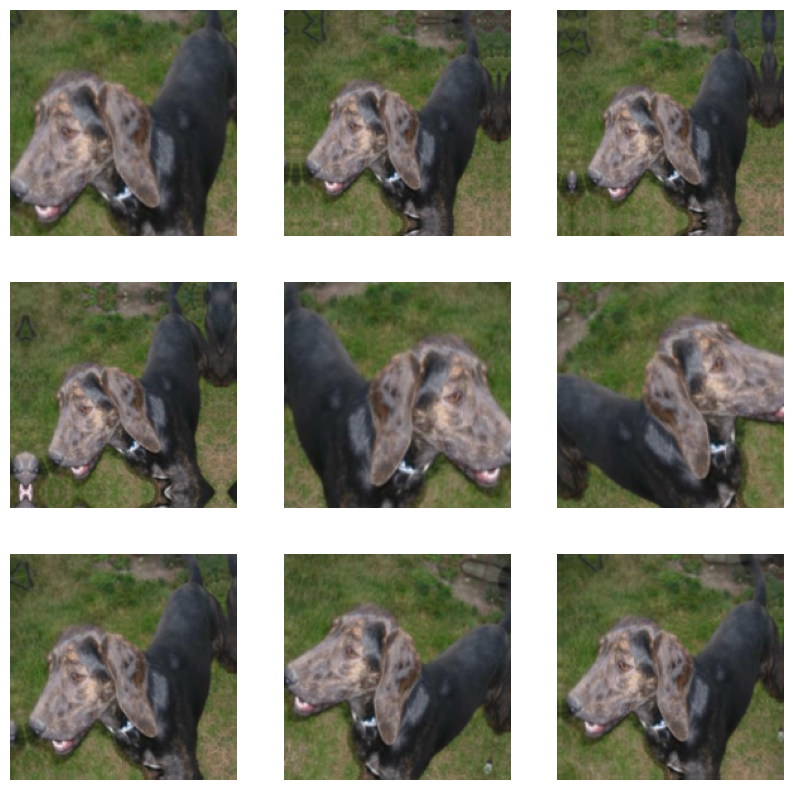

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
inputs= keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='convnet_from_scratch_with_augmentation.keras',
        save_best_only=True,
        monitor='val_loss')
]

In [14]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4935 - loss: 0.7001 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5356 - loss: 0.6932 - val_accuracy: 0.6060 - val_loss: 0.6689
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5806 - loss: 0.6840 - val_accuracy: 0.6110 - val_loss: 0.6529
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5857 - loss: 0.6687 - val_accuracy: 0.5010 - val_loss: 0.9118
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6419 - loss: 0.6529 - val_accuracy: 0.6200 - val_loss: 0.6407
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6634 - loss: 0.6223 - val_accuracy: 0.5190 - val_loss: 1.5977
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6385 - loss: 0.6578 - val_accuracy: 0.6780 - val_loss: 0.5799
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6746 - loss: 0.6089 - val_accuracy: 0.

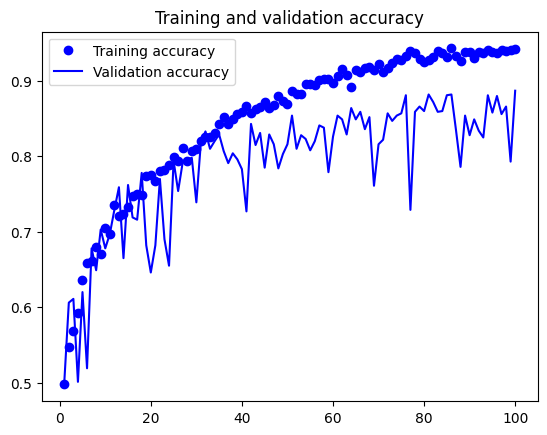

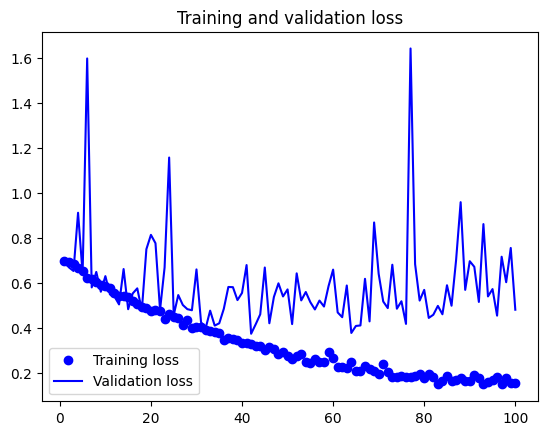

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
model.summary(line_length=80)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)        │ (None, 180, 180, 3)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ sequential (Sequential)           │ (None, 180, 180, 3)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ rescaling (Rescaling)             │ (None, 180, 180, 3)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d (Conv2D)                   │ (None, 178, 178, 32)     │           896 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)      │ (None, 89, 89, 32)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)                 │ (None, 87, 87, 64)       │        18,496 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)    │ (None, 43, 43, 64)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)                 │ (None, 41, 41, 128)      │        73,856 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)    │ (None, 20, 20, 128)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)                 │ (None, 18, 18, 256)      │       295,168 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)    │ (None, 9, 9, 256)        │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)                 │ (None, 7, 7, 256)        │       590,080 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ flatten (Flatten)                 │ (None, 12544)            │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout (Dropout)                 │ (None, 12544)            │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense (Dense)                     │ (None, 1)                │        12,545 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 1,982,084 (7.56 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 991,043 (3.78 MB)

In [36]:
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg", origin="https://img-datasets.s3.amazonaws.com/cat.jpg"
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

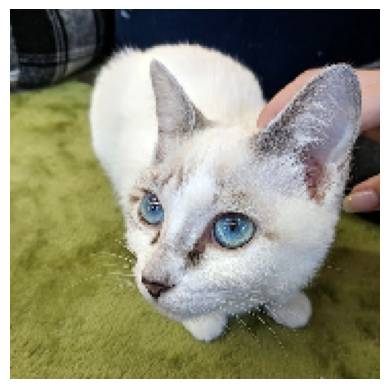

In [38]:
plt.axis('off')
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

In [39]:
from keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [40]:
activations = activation_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


In [41]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


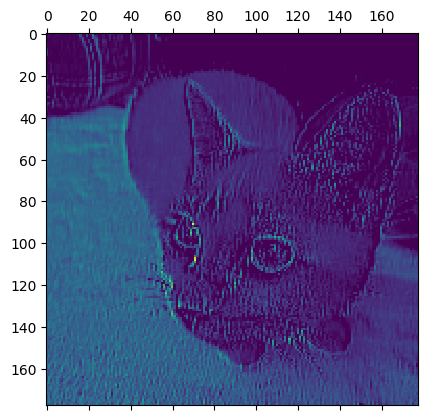

In [44]:
plt.matshow(first_layer_activation[0, :, :, 1], cmap="viridis")

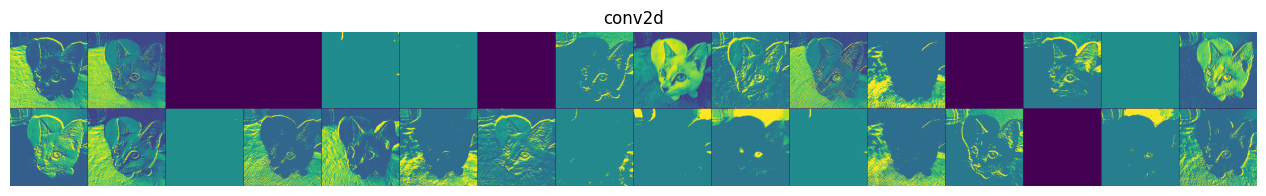

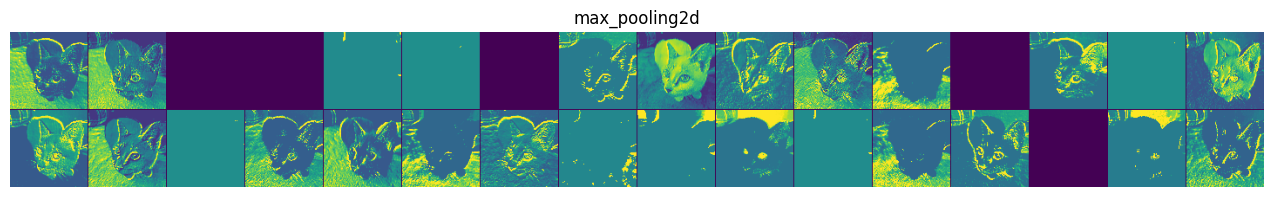

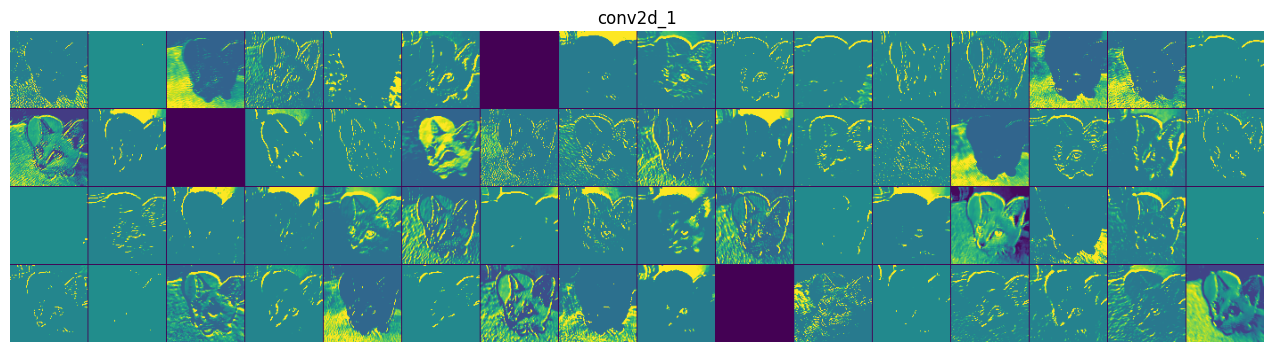

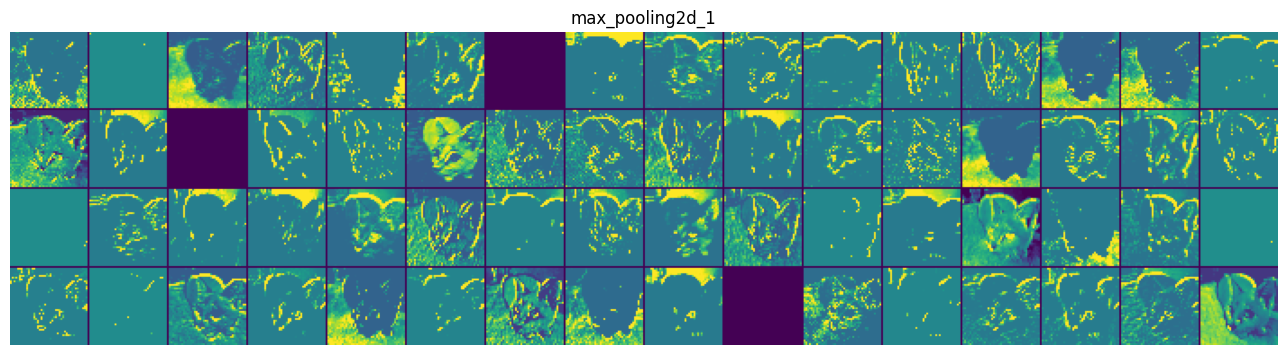

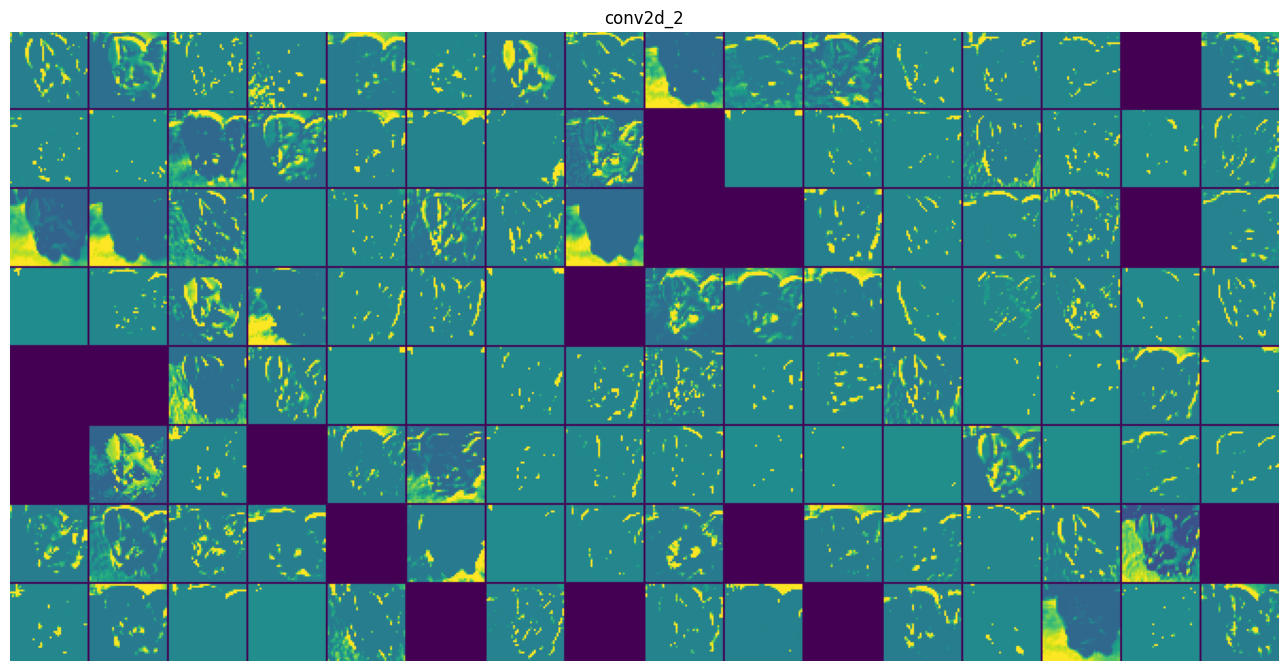

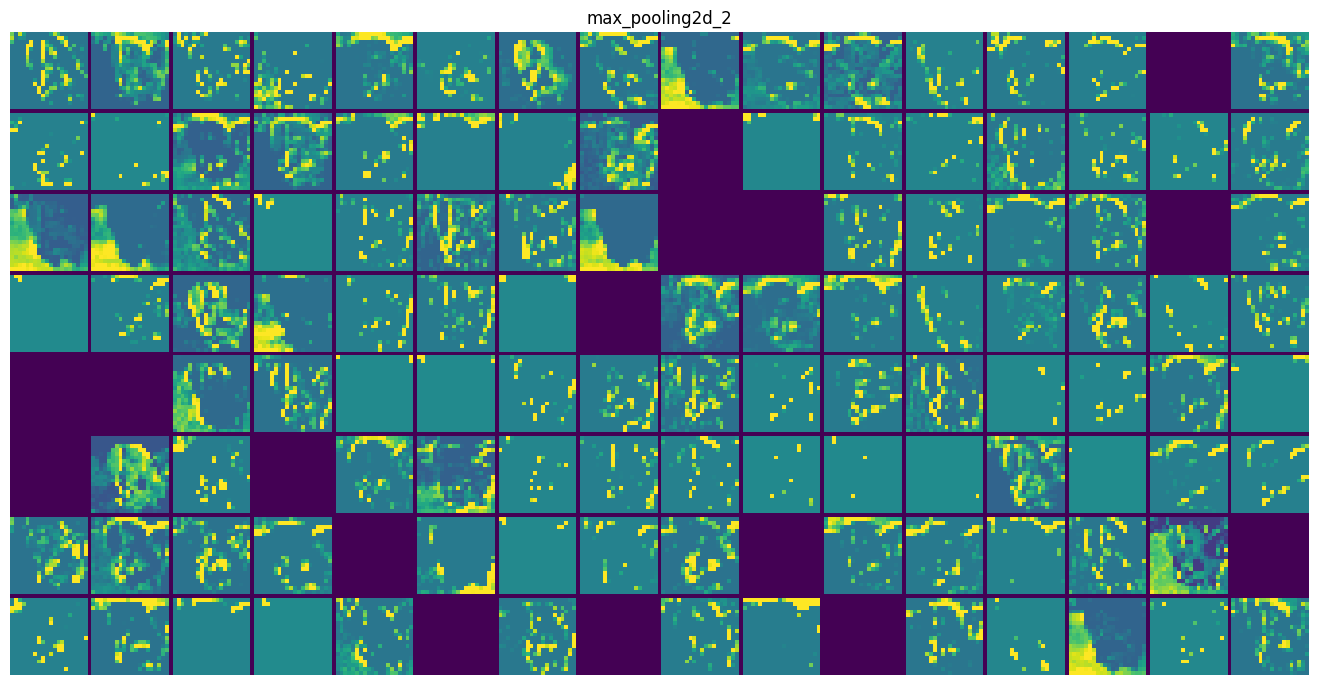

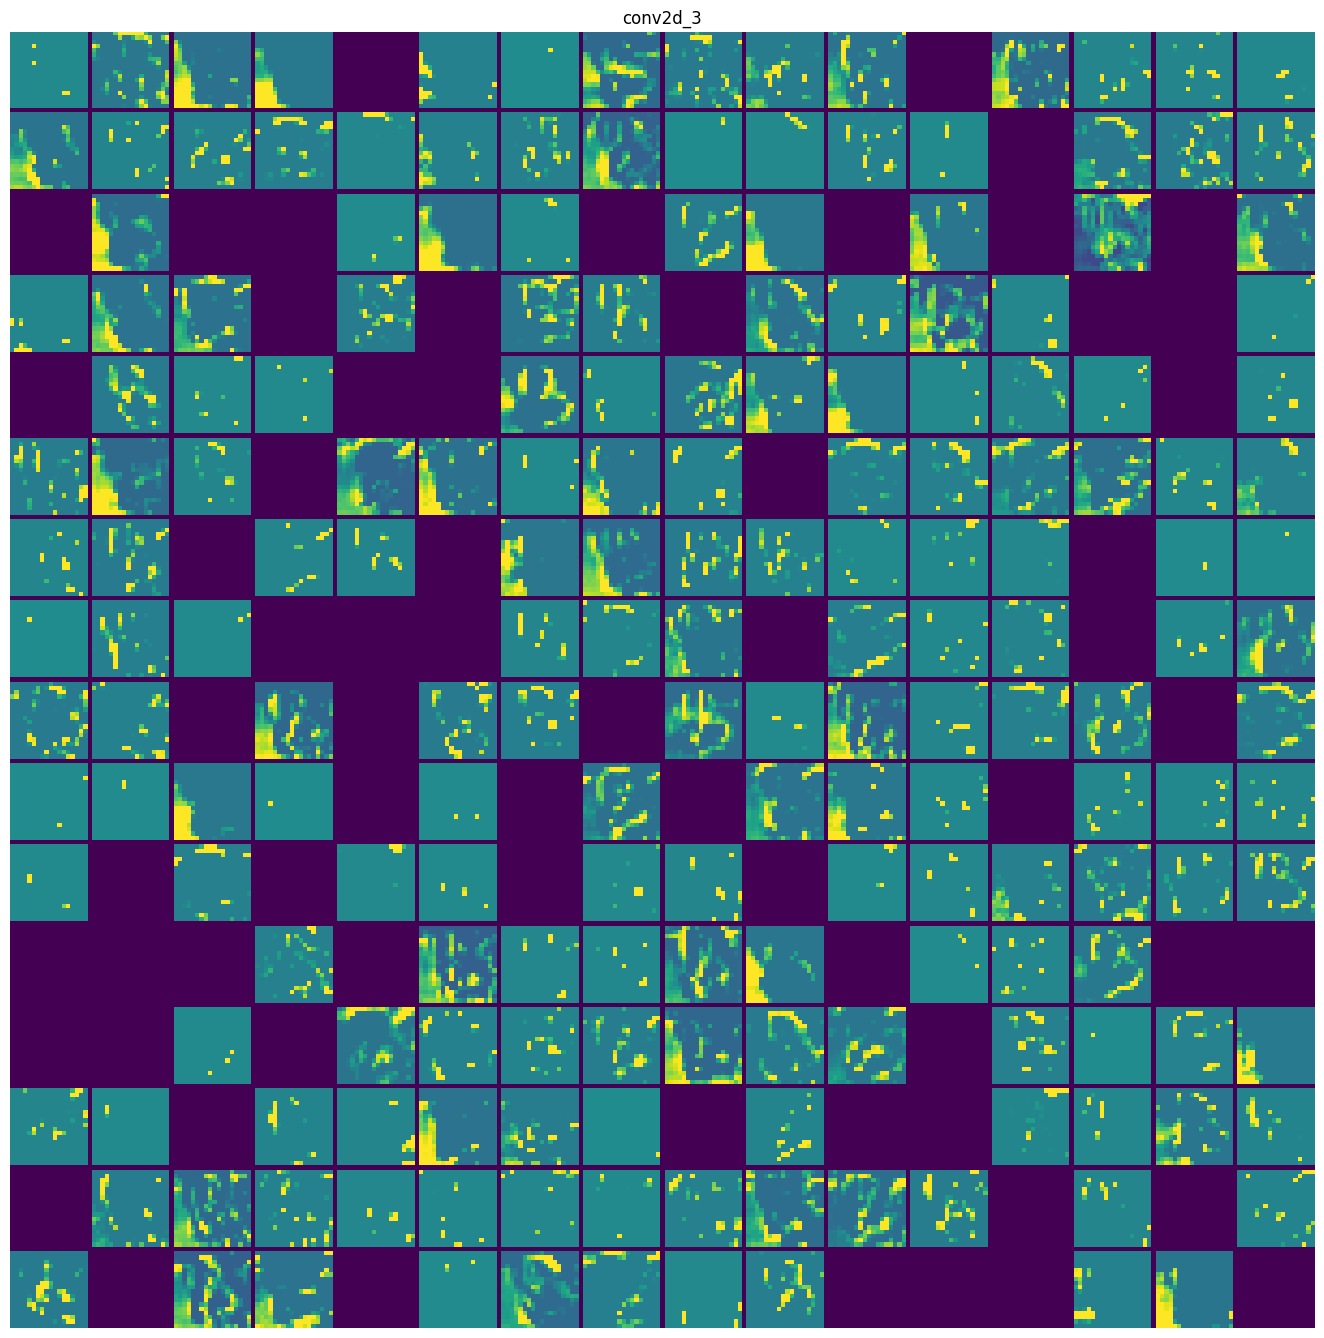

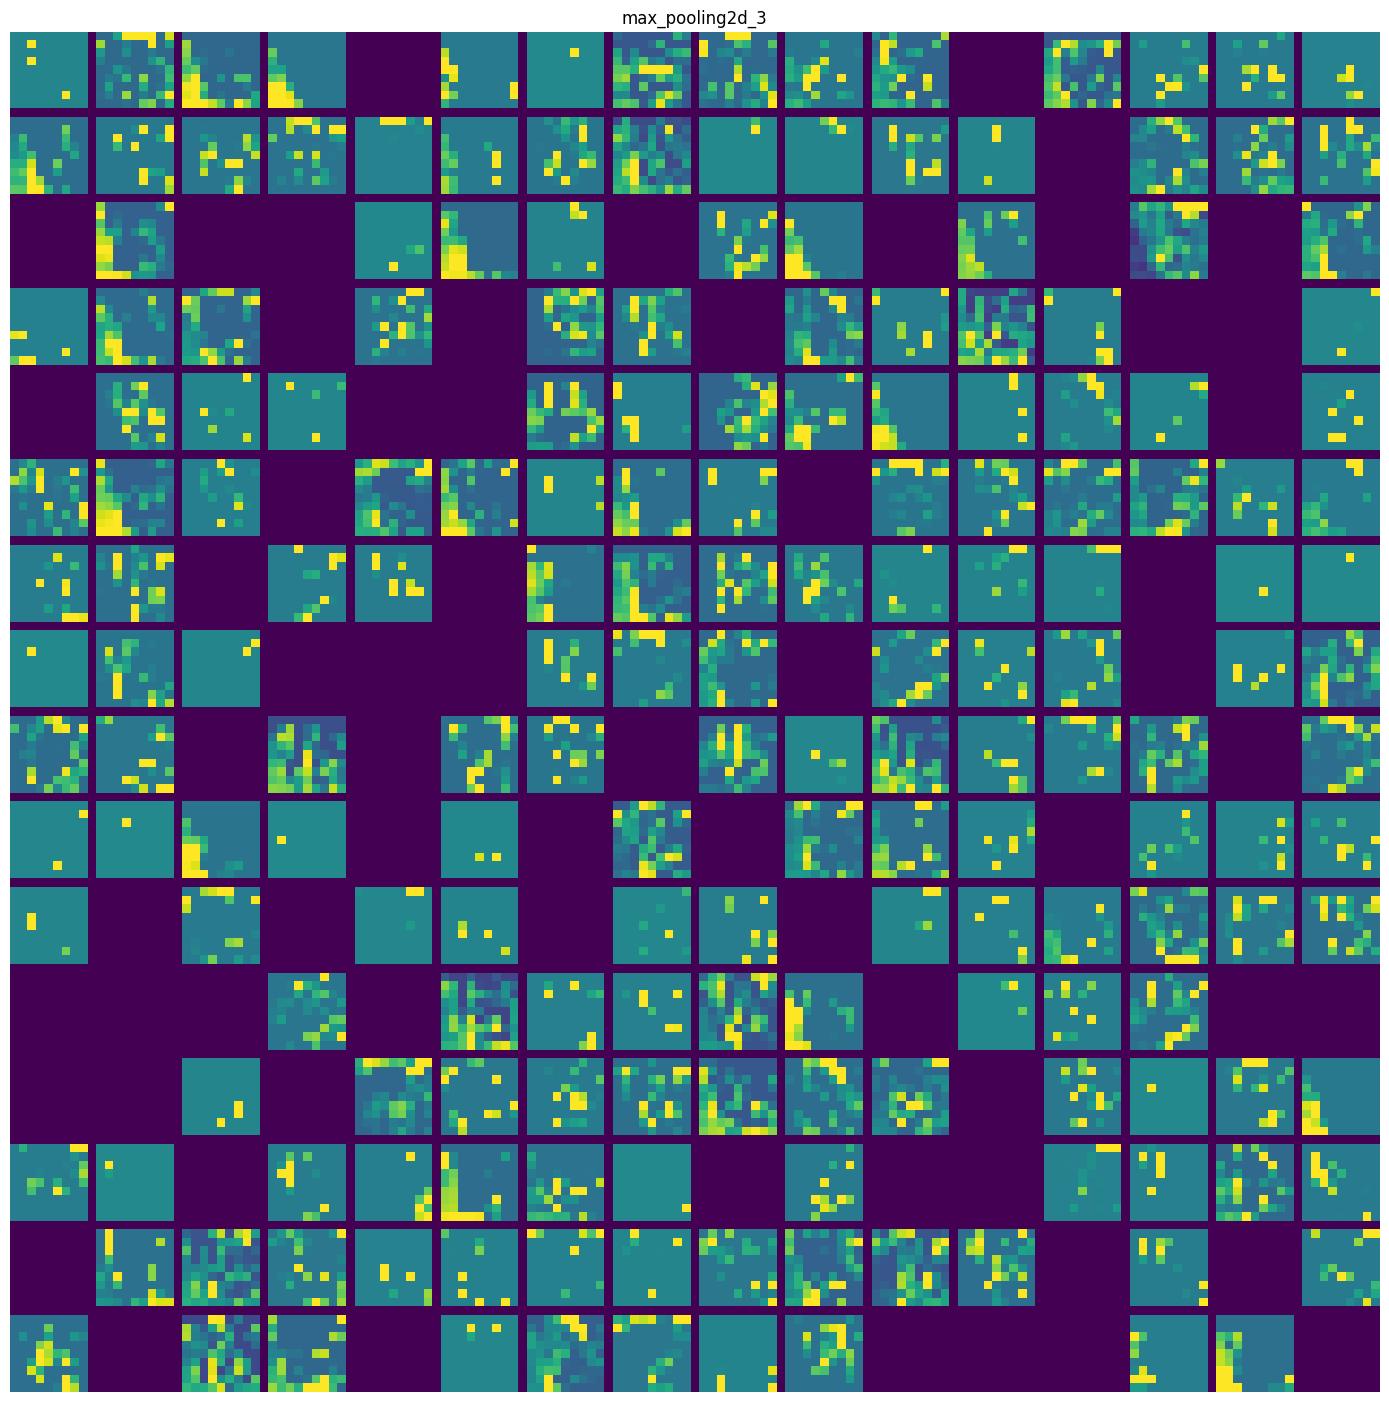

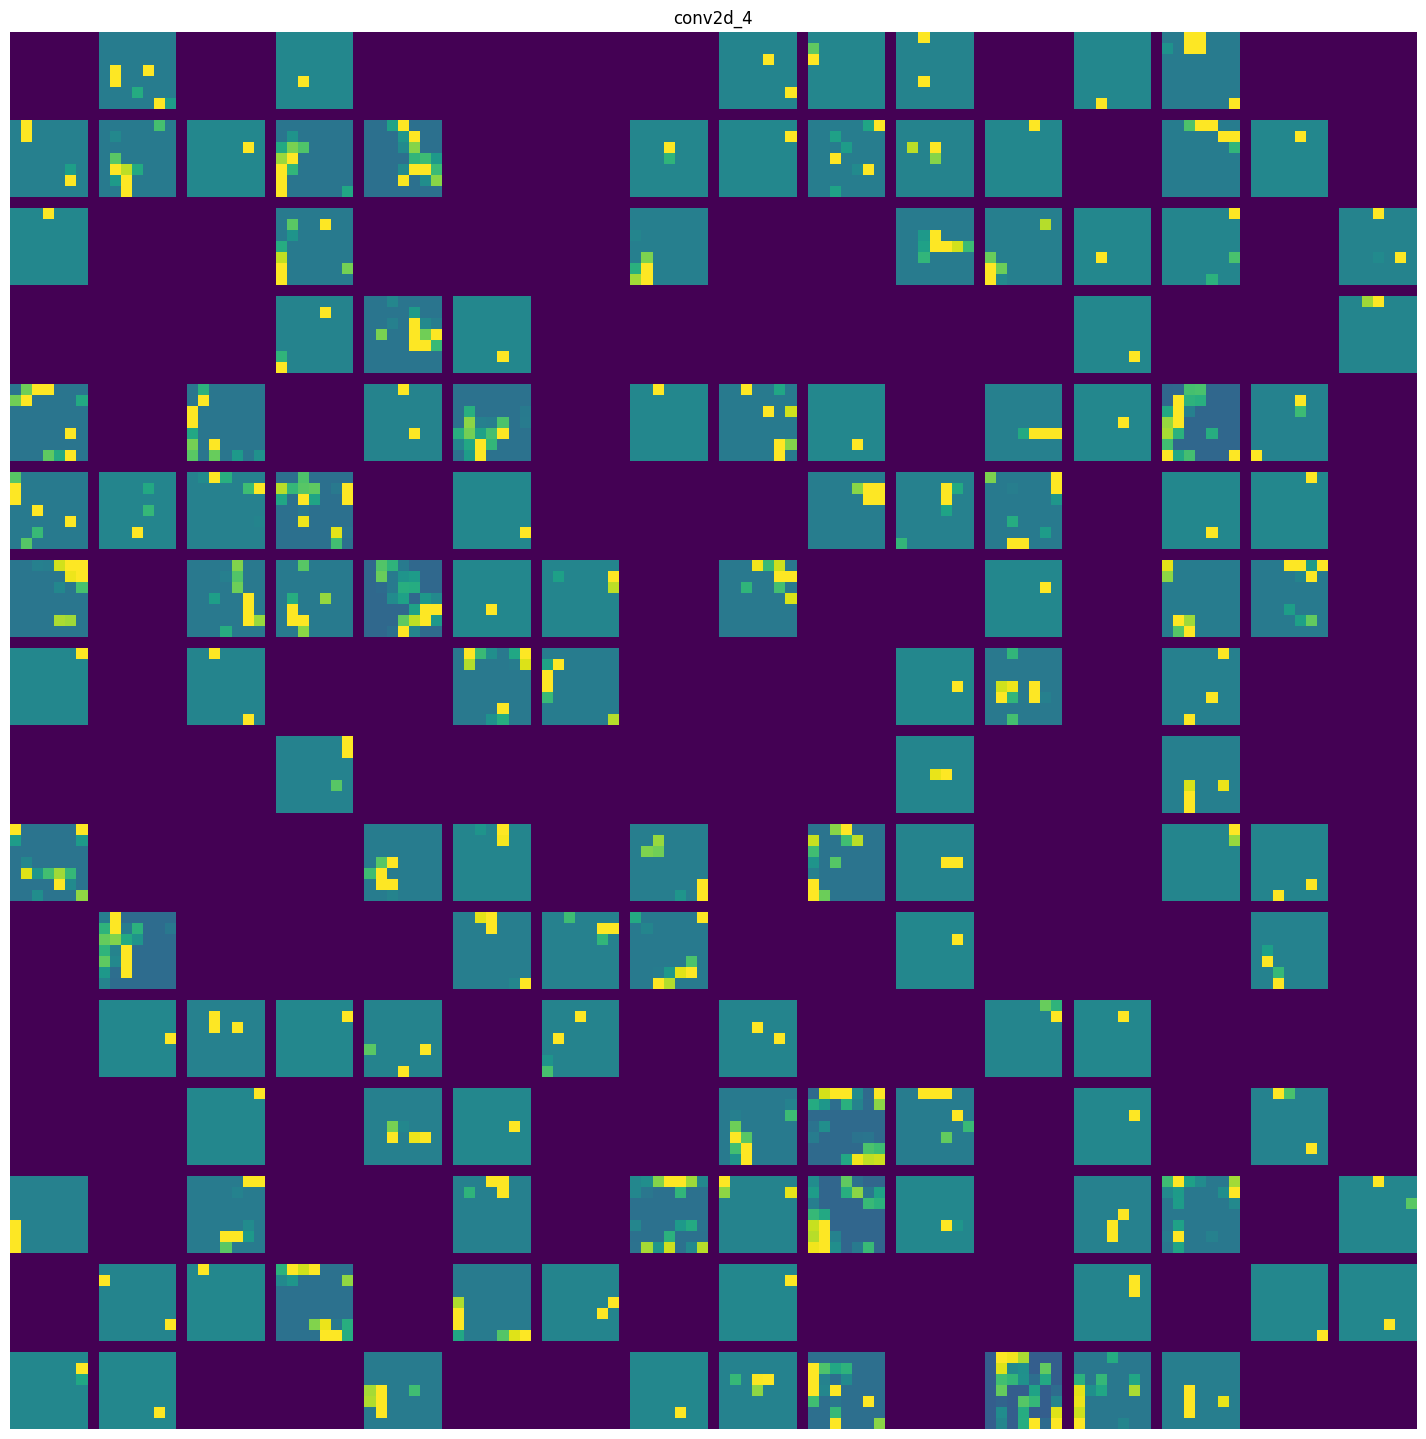

In [45]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(
        ((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1)
    )
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1) : (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row,
            ] = channel_image
    scale = 1.0 / size
    plt.figure(
        figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0])
    )
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")